In [1]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
import torch

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/malware-analysis-datasets-api-call-sequences/dynamic_api_call_sequence_per_malware_100_0_306.csv


# **Class to config 40 seed and for batch size 64 each Model**

In [2]:
class cfg:
    FOLD = 0
    SEEDS = [42]
    batch_size = 64
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Creating Data Frame from the Dataset

In [3]:
data = pd.read_csv("../input/malware-analysis-datasets-api-call-sequences/dynamic_api_call_sequence_per_malware_100_0_306.csv")

In [4]:
data.head()


,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,1


# **Droping column of each feature that having null**

In [5]:
data1 = data.drop(columns=['hash'],

                 axis=1)
data1 = data1.dropna(how='any')
print(data1.shape)

(43876, 101)


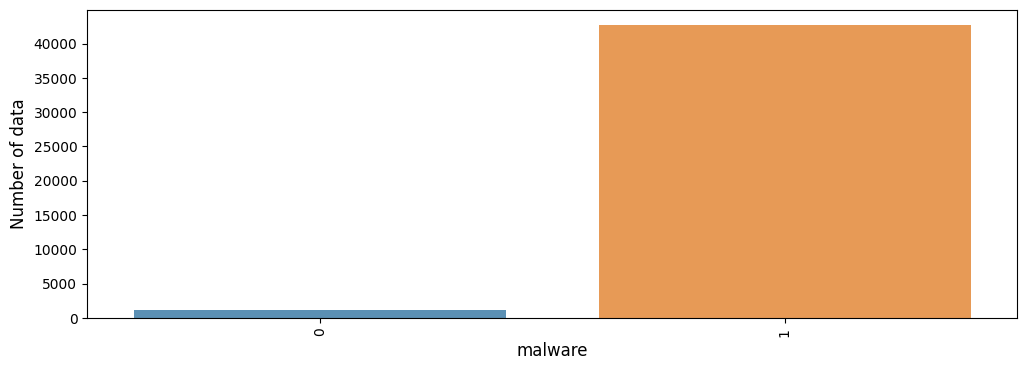

In [6]:
cnt_pro = data1['malware'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values ,alpha=0.8)
plt.ylabel('Number of data', fontsize=12)
plt.xlabel('malware', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [7]:
data_dict = {}
for label, group in data1.groupby('malware'):
    data_dict[label] = group.sample(min(group.shape[0], 4000))
data2 = pd.concat(data_dict.values())
data2 = data2.reset_index()

In [8]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
for fold, (_, val_idx) in enumerate(skf.split(data2, data2.malware)):
    data2.loc[val_idx, 'fold'] = fold
data2.fold = data2.fold.astype(int)

In [9]:
data2.to_csv('malware-analysis-1000.csv')

# **Machine Learning**

In [10]:
X_train = data2.query(f'fold!={cfg.FOLD}').drop(columns=['index','malware','fold'])
X_test = data2.query(f'fold=={cfg.FOLD}').drop(columns=['index','malware','fold'])

Y_train = data2.query(f'fold!={cfg.FOLD}').malware
Y_test = data2.query(f'fold=={cfg.FOLD}').malware

In [11]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', Y_train.shape)
print('X test shape: ', X_test.shape)
print('Y test shape: ', Y_test.shape)

X train shape:  (4063, 100)
Y train shape:  (4063,)
X test shape:  (1016, 100)
Y test shape:  (1016,)


In [12]:
from sklearn.feature_extraction.text import TfidfTransformer

In [13]:
def get_freq(data):
    data_cnt = []
    for i, row in data.iterrows():
        item = np.zeros((307,))
        cnts = row.value_counts()
        item[cnts.keys()] = cnts.values
        data_cnt.append(item)
    data_cnt = np.stack(data_cnt)
    return data_cnt


In [14]:
transformer = TfidfTransformer()
X_train_cnt = get_freq(X_train)
X_test_cnt = get_freq(X_test)

transformer.fit(X_train_cnt)

X_train_tfidf = transformer.transform(X_train_cnt).toarray()
X_test_tfidf = transformer.transform(X_test_cnt).toarray()

In [15]:
def train(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    test_acc_mlp = model.score(X_test, Y_test)
    train_acc_mlp = model.score(X_train, Y_train)
    prediction = model.predict(X_test)
    precision = precision_score(Y_test, prediction)
    recall = recall_score(Y_test, prediction)
    return precision, recall

In [16]:
def evaluate_model(M, X_train, Y_train, X_test, Y_test):
    trn_acc = 0
    test_acc = 0
    models = []
    for seed in cfg.SEEDS:
        model = M(random_state=seed)
        _trn_acc, _test_acc = train(model, X_train, Y_train, X_test, Y_test)
        trn_acc += _trn_acc
        test_acc += _test_acc
        models.append(model)
    trn_acc = round(trn_acc/len(cfg.SEEDS) * 100, 2)
    test_acc = round(test_acc/len(cfg.SEEDS) * 100, 2)
    return trn_acc, test_acc, models

In [17]:
from tqdm.auto import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import average_precision_score, precision_score, recall_score
import scikitplot as skplt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [18]:
from functools import partial
import lightgbm as lgb
from sklearn import svm

In [19]:
model_factory = {}
model_factory['svm'] = svm.LinearSVC
model_factory['svm-rbf'] = partial(svm.SVC, kernel='rbf')
model_factory['lgb'] = lgb.LGBMClassifier
model_factory['mlp'] = partial(MLPClassifier, hidden_layer_sizes=(100,100,100),max_iter=1000)

In [20]:
from sklearn.metrics import PrecisionRecallDisplay
perf = []

for name, model in model_factory.items():
    print(name)
    trn_acc0, test_acc0, models = evaluate_model(model, X_train, Y_train, X_test, Y_test)
    print(f"baseline: Train Accuracy {trn_acc0}, Test Accuracy {test_acc0}")
    print()
    perf.append({
        'model': name,
        'feature': 'baseline',
        'precision': trn_acc0,
        'recall': test_acc0,
    })


trainsy=[]
for name, model in model_factory.items():
    print(name)
    trn_acc1, test_acc1, models = evaluate_model(model, X_train_cnt, Y_train, X_test_cnt, Y_test)
    print(f"tf-idf:Train Accuracy {trn_acc1}, Test Accuracy {test_acc1}" )
    print()
    perf.append({
        'model': name,
        'feature': 'tf-idf',
        'precision': trn_acc1,
        'recall': test_acc1,
    })

svm
baseline: Train Accuracy 89.16, Test Accuracy 97.62

svm-rbf
baseline: Train Accuracy 92.82, Test Accuracy 98.62

lgb
baseline: Train Accuracy 94.28, Test Accuracy 98.88

mlp
baseline: Train Accuracy 93.71, Test Accuracy 95.0

svm
tf-idf:Train Accuracy 95.02, Test Accuracy 95.38

svm-rbf
tf-idf:Train Accuracy 92.78, Test Accuracy 94.75

lgb
tf-idf:Train Accuracy 97.04, Test Accuracy 98.25

mlp
tf-idf:Train Accuracy 97.01, Test Accuracy 97.5



In [21]:
pd.DataFrame(perf).set_index(['feature', 'model'])

precision  recall
feature  model                     
baseline svm          89.16   97.62
         svm-rbf      92.82   98.62
         lgb          94.28   98.88
         mlp          93.71   95.00
tf-idf   svm          95.02   95.38
         svm-rbf      92.78   94.75
         lgb          97.04   98.25
         mlp          97.01   97.50

# **Deep Learning**

In [22]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# **Loading The Dataset**

In [23]:
trn_dset = TensorDataset(torch.tensor(X_train.values), torch.tensor(Y_train.values))
test_dset = TensorDataset(torch.tensor(X_test.values), torch.tensor(Y_test.values))
trn_loader = DataLoader(trn_dset, shuffle=True, batch_size=cfg.batch_size)
test_loader = DataLoader(test_dset, shuffle=False, batch_size=cfg.batch_size)

# **RNN Model**

In [24]:
class RNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(307, 100)
        self.rnn = nn.GRU(input_size=100, hidden_size=50, num_layers=1, batch_first=True, bidirectional=True, dropout=0.2)
        self.rnn = nn.LSTM(input_size=100, hidden_size=50, num_layers=1, batch_first=True, bidirectional=True, dropout=0.2)
        self.classifier = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
    
    def forward(self, inp):
        emb = self.embedding(inp)
        feats, _ = self.rnn(emb)
        gl_feats = feats.mean(dim=1)
        probs = self.classifier(gl_feats).squeeze(-1)
        return probs


# **CNN Model**

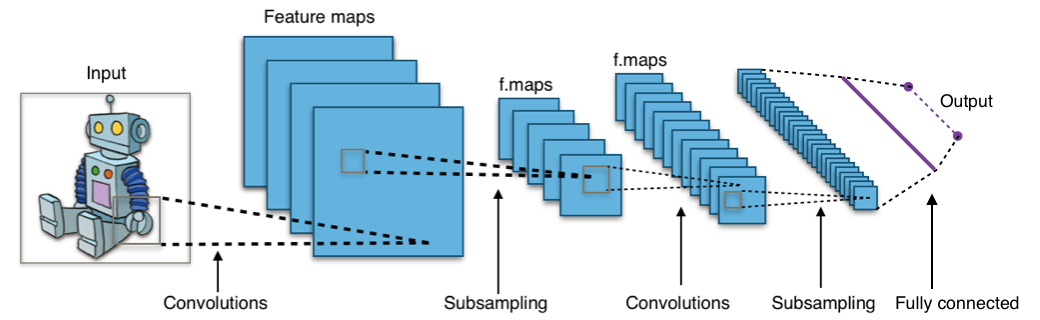

In [25]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(307, 100)
        self.cnn = nn.Sequential(
            nn.Conv1d(100, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Dropout(0.2),
            nn.MaxPool1d(2),
            nn.Conv1d(100, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Dropout(0.2),
            nn.MaxPool1d(2),
            nn.Conv1d(100, 100, kernel_size=3, padding=1),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
    
    def forward(self, inp):
        emb = self.embedding(inp)
        gl_feats = self.pool(self.cnn(emb.permute(0,2,1))).squeeze(-1)
        probs = self.classifier(gl_feats).squeeze(-1)
        return probs



# **Creating Factory Pattern Design For each Model ( CNN or RNN )**

In [26]:
nn_dict = {
    'CNN': CNN,
    "RNN": RNN
}

# **Binary Cross Entropy ||**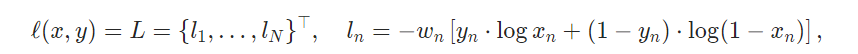

In [27]:
loss_fn = torch.nn.BCELoss()
def acc_fn(pred, label):
    return ((pred>0.5)==label).float().mean()

def precision_fn(pred,label):
    return ((pred>0.5)==label).float().sum()/(pred>0.5).float().sum()

def recall_fn(pred,label):
    return ((pred>0.5)==label).float().sum()/label.float().sum()

In [28]:
def train_nn(net, optimizer, trn_loader, test_loader):
    trn_losses = []
    trn_accs = []
    test_losses = []
    test_accs = []

    for epoch in tqdm(range(50)):
        net.train()
        loss = 0
        acc = 0
        total = 0
        for inp, label in trn_loader:
            inp = inp.to(cfg.device)
            label = label.to(cfg.device)
            bs = label.shape[0]
            pred = net(inp)
            _loss = loss_fn(pred, label.float())
            _acc = acc_fn(pred, label)
            optimizer.zero_grad()
            _loss.backward()
            optimizer.step()
            loss += _loss.item() * bs
            acc += _acc.item() * bs
            total += bs
        loss = loss/total
        acc = acc/total
        trn_losses.append(loss)
        trn_accs.append(acc)
        net.eval()
        loss = 0
        acc = 0
        total = 0
        with torch.no_grad():
            for inp, label in test_loader:
                inp = inp.to(cfg.device)
                label = label.to(cfg.device)
                bs = label.shape[0]
                pred = net(inp)
                _loss = loss_fn(pred, label.float())
                _acc = acc_fn(pred, label)
                loss += _loss.item() * bs
                acc += _acc.item() * bs
                total += bs
        loss = loss/total
        acc = acc/total
        test_losses.append(loss)
        test_accs.append(acc)
        torch.save(net.state_dict(), f'checkpoint-epoch{epoch}.pth')
    best_epoch = np.argmax(test_accs)
    print(f"The best epoch :{best_epoch} ,Best train accuracy: {trn_accs[best_epoch]} ,  Best Test accuracy: {test_accs[best_epoch]}")
    net.load_state_dict(torch.load(f'checkpoint-epoch{best_epoch}.pth'))
    net.eval()
    prediction = []
    with torch.no_grad():
        for inp, label in test_loader:
            inp = inp.to(cfg.device)
            label = label.to(cfg.device)
            bs = label.shape[0]
            pred = net(inp)
            prediction.append(pred.data.cpu().numpy())
    prediction = np.concatenate(prediction, axis=0)
    return prediction

In [29]:
for name, NN in nn_dict.items():
    net = NN().to(cfg.device)
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
    print(name)
    prediction = train_nn(net, optimizer, trn_loader, test_loader)
    precision = precision_score(Y_test, prediction>0.5)
    recall = recall_score(Y_test, prediction>0.5)
    print(f"Precision: {precision} , Recall: {recall}")

CNN


  0%|          | 0/50 [00:00<?, ?it/s]

The best epoch :29 ,Best train accuracy: 0.990893428281056 ,  Best Test accuracy: 0.9803149643845446
Precision: 0.9899497487437185 , Recall: 0.985
RNN


  0%|          | 0/50 [00:00<?, ?it/s]

The best epoch :38 ,Best train accuracy: 0.9884321929608664 ,  Best Test accuracy: 0.9724409458205456
Precision: 0.9812967581047382 , Recall: 0.98375


In [30]:
class MModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(307, 100)
        self.cnn = nn.Sequential(
            nn.Conv1d(100, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Dropout(0.2),
            nn.MaxPool1d(2),
            nn.Conv1d(100, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Dropout(0.2),
            nn.MaxPool1d(2),
            nn.Conv1d(100, 100, kernel_size=3, padding=1),
        )
        self.fc = nn.Sequential(
            nn.Linear(307, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
    
    def forward(self, inp1, inp2):
        emb = self.embedding(inp1)
        gl_feats = self.pool(self.cnn(emb.permute(0,2,1))).squeeze(-1)
        
        feats2 = self.fc(inp2)
        probs = self.classifier(gl_feats + feats2).squeeze(-1)
        return probs



In [31]:
trn_dset = TensorDataset(torch.tensor(X_train.values), torch.tensor(X_train_cnt), torch.tensor(Y_train.values))
test_dset = TensorDataset(torch.tensor(X_test.values), torch.tensor(X_test_cnt), torch.tensor(Y_test.values))
trn_loader = DataLoader(trn_dset, shuffle=True, batch_size=cfg.batch_size)
test_loader = DataLoader(test_dset, shuffle=False, batch_size=cfg.batch_size)

In [32]:
net = MModel().to(cfg.device)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
loss_fn = torch.nn.BCELoss()
def acc_fn(pred, label):
    return ((pred>0.5)==label).float().mean()

In [33]:
trn_losses = []
trn_accs = []
test_losses = []
test_accs = []

for epoch in tqdm(range(50)):
    net.train()
    loss = 0
    acc = 0
    total = 0
    for inp1, inp2, label in trn_loader:
        inp1 = inp1.to(cfg.device)
        inp2 = inp2.to(cfg.device).float()
        label = label.to(cfg.device)
        bs = label.shape[0]
        pred = net(inp1, inp2)
        _loss = loss_fn(pred, label.float())
        _acc = acc_fn(pred, label)
        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()
        loss += _loss.item() * bs
        acc += _acc.item() * bs
        total += bs
    loss = loss/total
    acc = acc/total
    trn_losses.append(loss)
    trn_accs.append(acc)
    net.eval()
    loss = 0
    acc = 0
    total = 0
    with torch.no_grad():
        for inp1, inp2, label in test_loader:
            inp1 = inp1.to(cfg.device)
            inp2 = inp2.to(cfg.device).float()
            label = label.to(cfg.device)
            bs = label.shape[0]
            pred = net(inp1, inp2)
            _loss = loss_fn(pred, label.float())
            _acc = acc_fn(pred, label)
            loss += _loss.item() * bs
            acc += _acc.item() * bs
            total += bs
    loss = loss/total
    acc = acc/total
    test_losses.append(loss)
    test_accs.append(acc)
print(f'Train accuracy: {max(trn_accs)} , Test accuracy: {max(test_accs)}')

  0%|          | 0/50 [00:00<?, ?it/s]

Train accuracy: 0.9963081466896382 , Test accuracy: 0.9763779565105288
